<a href="https://colab.research.google.com/github/grace-arina/Diagnosing-Pneumonia_CNN/blob/Olgert/Olgert_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
np.random.seed(123)

import scipy
import os, shutil
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, SeparableConv2D , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [14]:
image_size = (128,128)
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/train",
    image_size=image_size,
    batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/test",
    image_size=image_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/val",
    image_size=image_size,
    batch_size=batch_size)


Found 5022 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 210 files belonging to 2 classes.


In [15]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 128, 128, 3)
(50,)


In [17]:
tpain = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=tpain)
val_ds = val_ds.prefetch(buffer_size=tpain)

In [18]:
	from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom

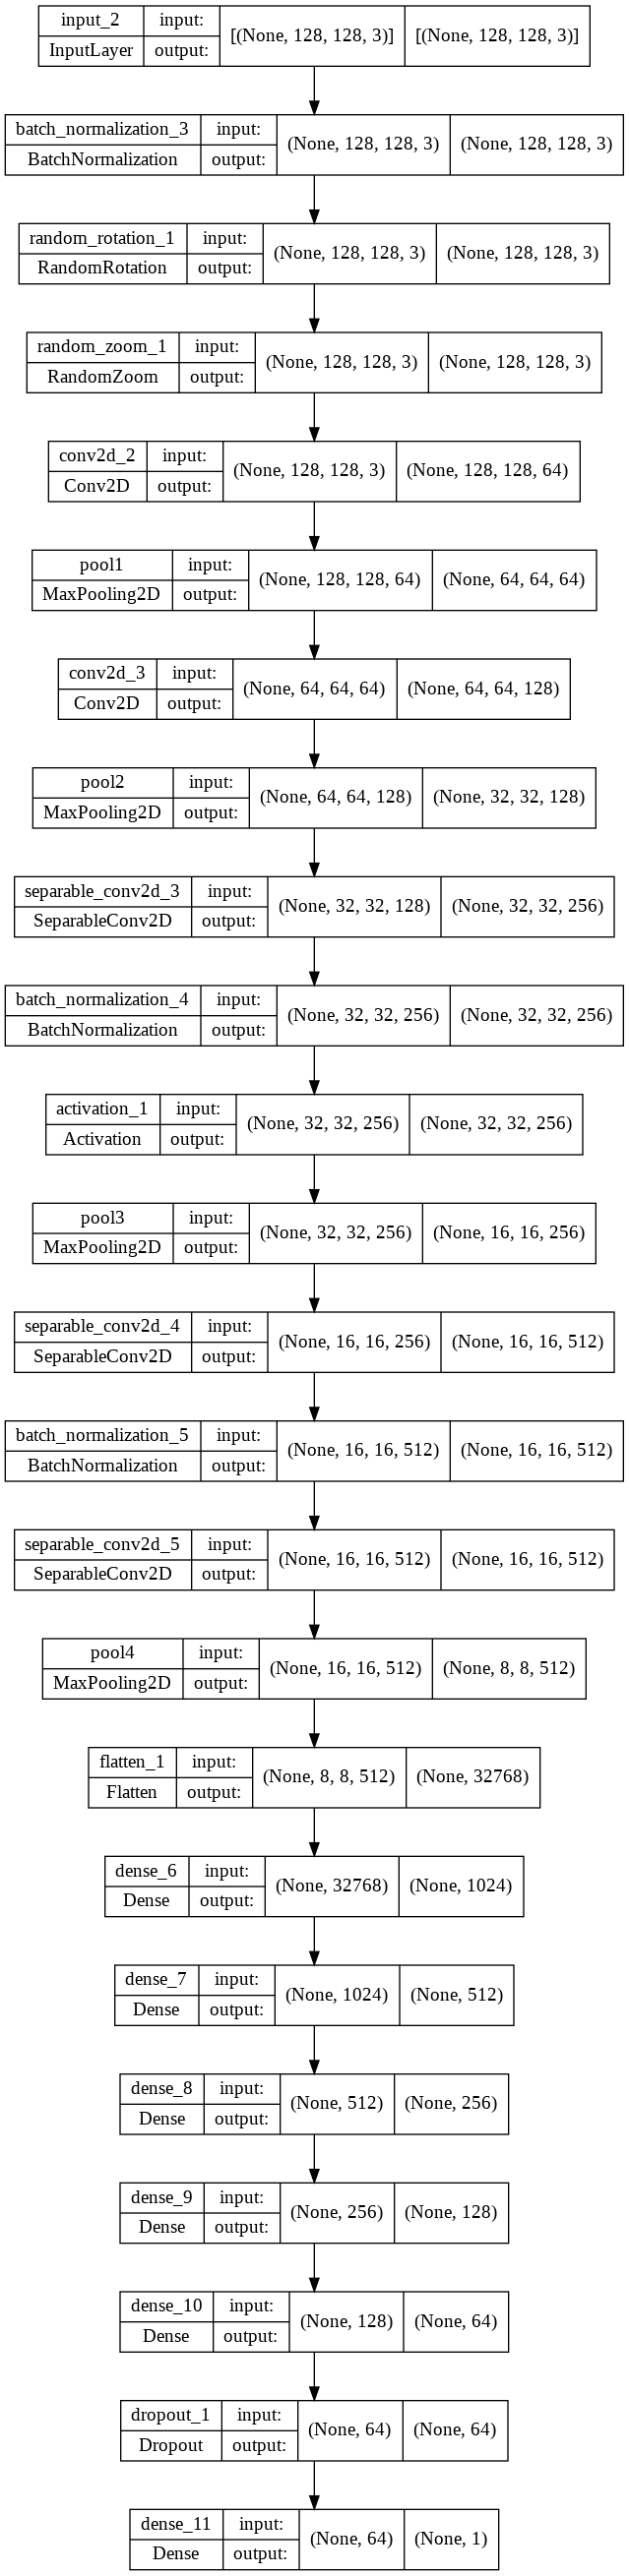

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block

    x = layers.BatchNormalization()(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomZoom(0.2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)            
    x = layers.SeparableConv2D(512,3, padding="same")(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)   
    previous_block_activation = x  # Set aside residual

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0   

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

In [22]:
model.compile(optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"])
early_stop = EarlyStopping(monitor= "val_loss", patience = 20, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model.hdf5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.001)

result = model.fit(train_ds, epochs=50, validation_data=val_ds, shuffle=True, callbacks=[early_stop,mod_checkpt,lr_rate])

Epoch 1/50
101/101 [==============================] - 66s 632ms/step - loss: 0.3348 - accuracy: 0.8584 - val_loss: 1.0033 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - 61s 602ms/step - loss: 0.2280 - accuracy: 0.9136 - val_loss: 2.3549 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - 60s 593ms/step - loss: 0.2099 - accuracy: 0.9219 - val_loss: 1.7866 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - 61s 598ms/step - loss: 0.1919 - accuracy: 0.9307 - val_loss: 1.5926 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 5/50
101/101 [==============================] - 65s 639ms/step - loss: 0.1918 - accuracy: 0.9307 - val_loss: 0.9871 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 6/50
101/101 [==============================] - 65s 641ms/step - loss: 0.1784 - accuracy: 0.9373 - val_loss: 0.3990 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 7/50
101/101 [==============================] 

In [23]:
results_train = model.evaluate(train_ds) 

101/101 [==============================] - 13s 129ms/step - loss: 0.0866 - accuracy: 0.9681


In [24]:
 results_test = model.evaluate(test_ds)

13/13 [==============================] - 8s 226ms/step - loss: 0.5640 - accuracy: 0.7917


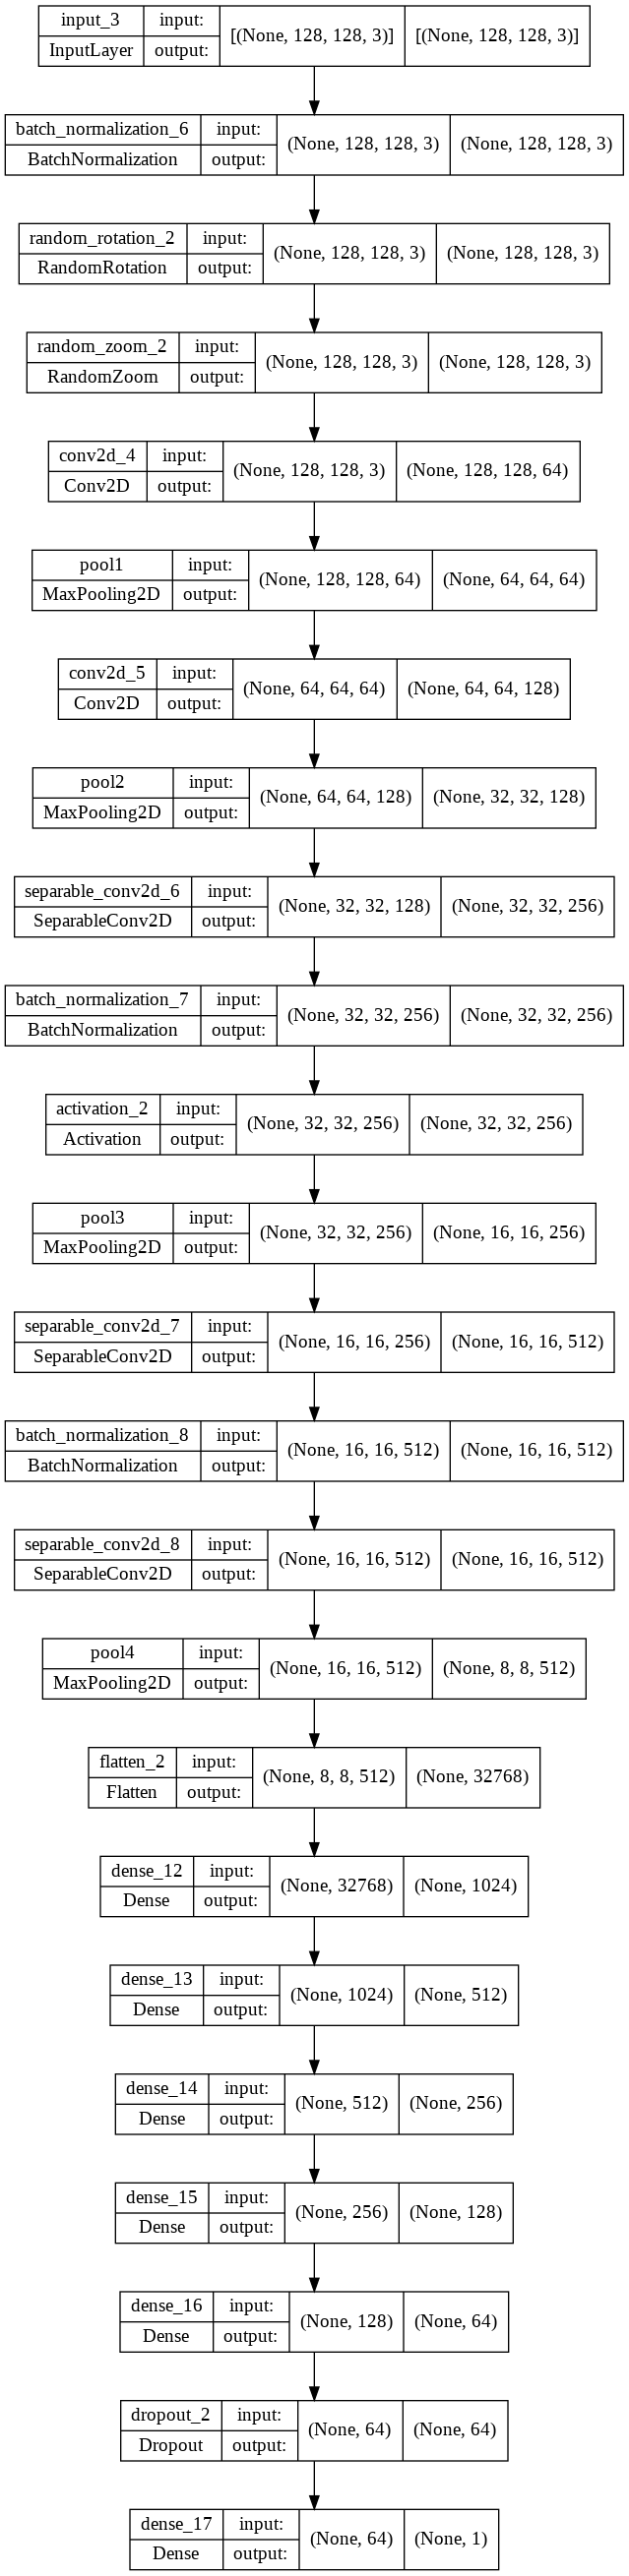

In [25]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block

    x = layers.BatchNormalization()(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.3)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)            
    x = layers.SeparableConv2D(512,3, padding="same")(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)   
    previous_block_activation = x  # Set aside residual

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"])
early_stop = EarlyStopping(monitor= "val_loss", patience = 20, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model.hdf5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.001)

result = model.fit(train_ds, epochs=500, validation_data=val_ds, shuffle=True, callbacks=[early_stop,mod_checkpt,lr_rate])